In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from langdetect import detect, DetectorFactory
import re   
from google.cloud import translate
import os
import time
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS


### Data Cleansing

In [ ]:
df = pd.read_excel("data.xlsx")
#fills the empty cells
df.fillna('-')
#extra list of comments
list_of_comments = df['Verbatim']

In [183]:

# The following lines of code cleans the Touchpoint column of the dataset
df['Touchpoint'] = df['Touchpoint'].str.replace('&lt;item&gt;', '')
df['Touchpoint'] = df['Touchpoint'].str.replace('&lt;/item&gt;', ', ')
df["Touchpoint"].head()


0                                             Branch, 
1                         ATM, Cash Deposit Machines, 
2    RHB Mobile Banking Application, ATM, Cash Depo...
3                 Branch, ATM, Cash Deposit Machines, 
4                               RHB Internet Banking, 
Name: Touchpoint, dtype: object

### Detecing Language-Using Google's API

In [125]:
# Initialize Translation client
# Please insert project ID from google cloud before use
def detect_lang_text(text, project_id=""):
    """Translating Text."""
    client = translate.TranslationServiceClient()

    location = "global"

    parent = f"projects/{project_id}/locations/{location}"

    # Translate text from English to French
    # Detail on supported types can be found here:
    # https://cloud.google.com/translate/docs/supported-formats

    if (text):
        lang_detect = client.detect_language(
            content=text,
            parent=parent,
            mime_type="text/plain",  # mime types: text/plain, text/html
        )
        lang_detected=lang_detect.languages[0].language_code
    else:
        lang_detected="en"
    # Display list of detected languages sorted by detection confidence.
    # The most probable language is first.
    # print(type(text))
    if(not lang_detected):
        lang_detected="en"
    return lang_detected

In [ ]:
clean_verbatim = []
lang_detected=[]
const=len(list_of_comments)
for i,n in enumerate(list_of_comments):
    cleaned_output = re.sub(r'[^a-zA-z\s]','',str(n))
    cleaned_output = cleaned_output.lower()
    detected_lang=detect_lang_text(cleaned_output)
    #store to a temporary array
    clean_verbatim +=[cleaned_output]
    lang_detected += [detected_lang]

#insert to df
df.insert(4, "Lang Detected", lang_detected, True)
df["Verbatim"]=clean_verbatim

In [148]:
#write df to csv for caching results
df.to_csv("language_tagged.csv")

,Created,Date,Touchpoint,Rating,Lang Detected,Verbatim,Preferred Bank,Product,ID
0,8/27/2020 4:42:25 PM,8/27/2020 16:42:24,"Branch,",7,ms,talian careline susah dijawab harus diperbaiki,RHB,CASA,bedba74e-1c23-4772-9ca9-6bf81bd1b27f
1,8/27/2020 5:22:49 PM,8/27/2020 17:22:33,"ATM, Cash Deposit Machines,",6,ms,tiada atm atau rhb di jasin melaka,Maybank,CASA,e170ee8d-1287-4f22-b597-c1f2d2b3e2cc
2,8/27/2020 5:50:18 PM,8/27/2020 17:50:17,"RHB Mobile Banking Application, ATM, Cash Depo...",6,en,up grade your apps,Affin Bank CIMB,CASA,feb9fc8d-15c3-407b-961a-e1f09677f3d0
3,8/27/2020 8:12:22 PM,8/27/2020 20:12:19,"Branch, ATM, Cash Deposit Machines,",10,ms,mengekalkan perkhidmatan seperti sekarang dan ...,Rhb bank di petaling jaya ss2.,CASA,22990519-8eb0-4a16-9e07-c9050c50e520
4,8/27/2020 8:14:38 PM,8/27/2020 20:14:36,"RHB Internet Banking,",5,en,hope can improve mobile app factions or link b...,ocbc pub,CASA,d2122a89-2eef-43e0-b8f8-44d399c04498
...,...,...,...,...,...,...,...,...,...
195,8/28/2020 7:58:43 AM,8/28/2020 7:58:45,"Branch, Call centre,",8,ms,perbank internet menyediakan pelbagai perkhidm...,MAYBANK,PF,9250b073-17c1-4a43-98d2-5f7e11874336
196,8/28/2020 8:01:49 AM,8/28/2020 8:1:46,"ATM, Cash Deposit Machines,",10,bs,servis,RHB Bank,PF,79ab2936-8164-401c-861d-ad0eac6407af
197,8/28/2020 8:02:25 AM,8/28/2020 8:2:23,"RHB Internet Banking,",10,en,no comment,No comment,PF,0455052f-e04e-476d-b9a4-dade90d10eb4
198,8/28/2020 9:09:35 AM,8/28/2020 9:9:31,"Branch, Social media, ATM, Cash Deposit Machin...",10,ms,kekalkan khidmat mesra pelanggan,Public Bank,PF,22e8c459-eabd-4128-98d1-3eae51b3a413


### Translating Verbatims to english

In [ ]:
# Initialize Translation client
# Please insert project ID from google cloud before use
def translate_text(text="",lang="en", project_id=""):
    """Translating Text."""
    start = time.time()

    client = translate.TranslationServiceClient()

    location = "global"

    parent = f"projects/{project_id}/locations/{location}"

    # Translate text from English to French
    # Detail on supported types can be found here:
    # https://cloud.google.com/translate/docs/supported-formats

    # Display list of detected languages sorted by detection confidence.
    # The most probable language is first.
    # print(type(text))
    if lang != "en" and lang !="und" and text :
        response = client.translate_text(
            request={
                "parent": parent,
                "contents": [text],
                "mime_type": "text/plain",  # mime types: text/plain, text/html
                "source_language_code": lang,
                "target_language_code": "en",
            }
        )
            # Display the translation for each input text provided
        translated_text = response.translations[0].translated_text
        end = time.time()
        print(f"{translated_text} ({end-start}s)")
        return translated_text


    return text

In [ ]:
# Translating all the cleaned_verbatims based on their original languages
df_lang_detected = pd.read_csv("language_tagged.csv")
lang_list = df_lang_detected['Lang Detected']
clean_verbatim = df_lang_detected["Verbatim"]
translated_verbatim_list = []

for (i,n) in enumerate(clean_verbatim):
    print(i)
    translated_verbatim=translate_text(text=str(n),lang=lang_list[i])
    translated_verbatim_list+=[translated_verbatim]
# Adding the translated Verbatims to the df
df_lang_detected.insert(4, "Verbatim Translated", translated_verbatim_list, True)

In [192]:
#caching results once again
df_lang_detected.to_csv("data_translated.csv")
df_lang_detected.head()

,Unnamed: 0,Created,Date,Touchpoint,Verbatim Translated,Rating,Lang Detected,Verbatim,Preferred Bank,Product,ID
0,0,8/27/2020 4:42:25 PM,8/27/2020 16:42:24,"Branch,",the hard -to -answer careline line needs to be...,7,ms,talian careline susah dijawab harus diperbaiki,na,CASA,bedba74e-1c23-4772-9ca9-6bf81bd1b27f
1,1,8/27/2020 5:22:49 PM,8/27/2020 17:22:33,"ATM, Cash Deposit Machines,",there is no atm or rhb in jasin melaka,6,ms,tiada atm atau rhb di jasin melaka,na,CASA,e170ee8d-1287-4f22-b597-c1f2d2b3e2cc
2,2,8/27/2020 5:50:18 PM,8/27/2020 17:50:17,"RHB Mobile Banking Application, ATM, Cash Depo...",up grade your apps,6,en,up grade your apps,na,CASA,feb9fc8d-15c3-407b-961a-e1f09677f3d0
3,3,8/27/2020 8:12:22 PM,8/27/2020 20:12:19,"Branch, ATM, Cash Deposit Machines,",maintain the service as it is now and gift som...,10,ms,mengekalkan perkhidmatan seperti sekarang dan ...,na,CASA,22990519-8eb0-4a16-9e07-c9050c50e520
4,4,8/27/2020 8:14:38 PM,8/27/2020 20:14:36,"RHB Internet Banking,",hope can improve mobile app factions or link b...,5,en,hope can improve mobile app factions or link b...,na,CASA,d2122a89-2eef-43e0-b8f8-44d399c04498


### Cleansing of the Preferred Banks

In [196]:
# list of banks in Msia based on https://en.wikipedia.org/wiki/List_of_banks_in_Malaysia
# hong represents hong leong bank, standard represents standard chartered, mbb is abbreviation for maybank since it is common for people to refer to maybank as mbb

list_of_banks = ["maybank", "mbb", "cimb", "public", "rhb", "hong", "ambank", "uob", "rakyat", "ocbc", "hsbc", "islam", "affin", "alliance", "standard", "mbsb", "citibank", "simpanan", "bsn","mualamat", "agro", "agrobank", "al-rajhi", "al rajhi", "pertama"]

In [198]:
# Futher cleaning of the preferred banks and splitting into their categories.
df_lang_detected['Preferred Bank'] = df_lang_detected['Preferred Bank'].str.lower()

user_input = df_lang_detected['Preferred Bank']
cleaned_preferred_banks = []
sentence = ""
for i in user_input:
    splitset_i = set(str(i).split())
    intersection_with_banks = list(splitset_i.intersection(list_of_banks))
    if len(intersection_with_banks) > 0:
        for j in intersection_with_banks:
            sentence += j + ", "
    else:
        sentence = "na"

    cleaned_preferred_banks += [sentence]
    sentence = ""


df_lang_detected['Preferred Bank'] = cleaned_preferred_banks


In [167]:
#caching results again
df_lang_detected.to_csv("data_cleaned.csv")

In [5]:
#Converting ratings into a binary
reviews_df = pd.read_csv("data_cleaned.csv")

reviews_df = reviews_df[['Verbatim Translated', 'Rating', 'Created']]
# print(reviews_df)
reviews_df['is_bad_review'] = reviews_df['Rating'].apply(lambda x:1 if x<5 else 0)


### Sentiment analysis

In [6]:
# Standard cleaning of the verbatims
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

import string
import nltk
from nltk import pos_tag
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import datetime as dt
from sklearn import preprocessing
from nltk.sentiment.vader import SentimentIntensityAnalyzer    
    
def clean_text(text):
    # lower text
    text = str(text).lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# Clean text data
reviews_df['Verbatim_Cleaned'] = reviews_df['Verbatim Translated'].apply(lambda x: clean_text(x))

# Initialize Sentiment Intensity
sid = SentimentIntensityAnalyzer()

# Perform Sentiment Analysis
reviews_df['sentiments'] = reviews_df['Verbatim Translated'].apply(lambda x: sid.polarity_scores(str(x)))


reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

# add number of char 
reviews_df['nb_chars'] = reviews_df['Verbatim Translated'].apply(lambda x:len(str(x)))

# add number of words column
reviews_df['nb_words'] = reviews_df['Verbatim Translated'].apply(lambda x:len(str(x).split(' ')))
reviews_df.head()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Verbatim Translated,Rating,Created,is_bad_review,Verbatim_Cleaned,neg,neu,pos,compound,nb_chars,nb_words
0,the hard -to -answer careline line needs to be...,7,8/27/2020 4:42:25 PM,0,hard answer careline line need fix,0.135,0.865,0.000,-0.1027,52,10
1,there is no atm or rhb in jasin melaka,6,8/27/2020 5:22:49 PM,0,atm rhb jasin melaka,0.216,0.784,0.000,-0.2960,38,9
2,up grade your apps,6,8/27/2020 5:50:18 PM,0,grade apps,0.000,1.000,0.000,0.0000,18,4
3,maintain the service as it is now and gift som...,10,8/27/2020 8:12:22 PM,0,maintain service gift something good use rhb,0.000,0.674,0.326,0.7003,71,14
4,hope can improve mobile app factions or link b...,5,8/27/2020 8:14:38 PM,0,hope improve mobile app faction link branch ac...,0.000,0.608,0.392,0.7003,70,12


### Computing Time Score and Urgency Scores

In [7]:
#formulation of the timescores and subsequently 
def normalize(df):
    x = df.values.reshape(-1,1) #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    return df

def compute_time_score(x,recent_timestamp):
    epoch=recent_timestamp.timestamp()/x.timestamp()
    return epoch

# clean text data
reviews_df['Created'] = reviews_df['Created'].astype('datetime64[ns]')

recent_timestamp = reviews_df['Created'].max()
print(recent_timestamp)
reviews_df["time_score"] = reviews_df["Created"].apply(lambda x: compute_time_score(x,recent_timestamp))

time_score = reviews_df["time_score"]

reviews_df["time_score"] = normalize(time_score).values
reviews_df["review_clean"] = reviews_df["Verbatim Translated"].apply(lambda x: clean_text(x))

reviews_df["normalised_rating"] = normalize(reviews_df["Rating"]).values
reviews_df["normalised_compound"] = normalize(reviews_df["compound"]).values

# compute urgency score
reviews_df["urgency_score"] = reviews_df["compound"] * reviews_df["time_score"]
reviews_df = reviews_df[["Created", "Verbatim_Cleaned", "compound", "time_score", "urgency_score","Rating"]]
reviews_df = reviews_df.sort_values("urgency_score")
reviews_df.head()

2021-12-07 23:04:30


,Created,Verbatim_Cleaned,compound,time_score,urgency_score,Rating
323,2020-09-09 15:15:37,leave name phone number extension moratorium b...,-0.9089,0.641814,-0.583345,5
559,2020-10-16 19:02:47,previously fd go branch instead online due cir...,-0.9667,0.588142,-0.568557,6
180,2020-08-27 15:25:04,change source debt collection teamthe team cal...,-0.8416,0.660633,-0.555989,6
165,2020-08-28 16:43:10,experienced lot difficulty last one year use r...,-0.8360,0.659105,-0.551012,7
218,2020-09-09 13:58:37,upgrade internet bank user friendly make numer...,-0.8162,0.641891,-0.523912,1


In [9]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [12]:
test_data = reviews_df.loc[reviews_df['urgency_score'] < -0.0]['Verbatim_Cleaned']
text = " ".join(review for review in test_data)

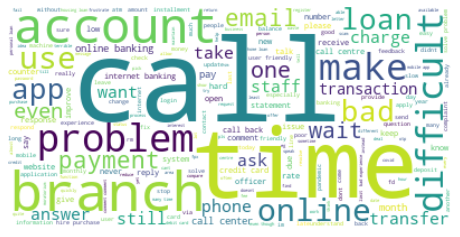

In [14]:
stopwords = set(STOPWORDS)
stopwords.update(["customer", "rhb", "bank", "service", "need", "go", "always"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)


fig = plot.figure(figsize = (8, 8))

# Display the generated image:
# the matplotlib way:
plot.imshow(wordcloud, interpolation='bilinear')
plot.axis("off")
plot.show()

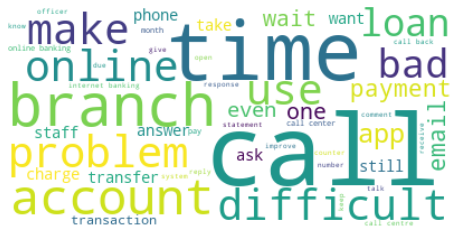

In [15]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, max_words=50, background_color="white").generate(text)

fig = plot.figure(figsize = (8, 8))

# Display the generated image:
# the matplotlib way:
plot.imshow(wordcloud, interpolation='bilinear')
plot.axis("off")
plot.show()

"Language Used" column indicates "ms" for Malay language verbatim and "en" for English language verbatim. Undefined language implies verbatim was not particularly useful and can be discarded.

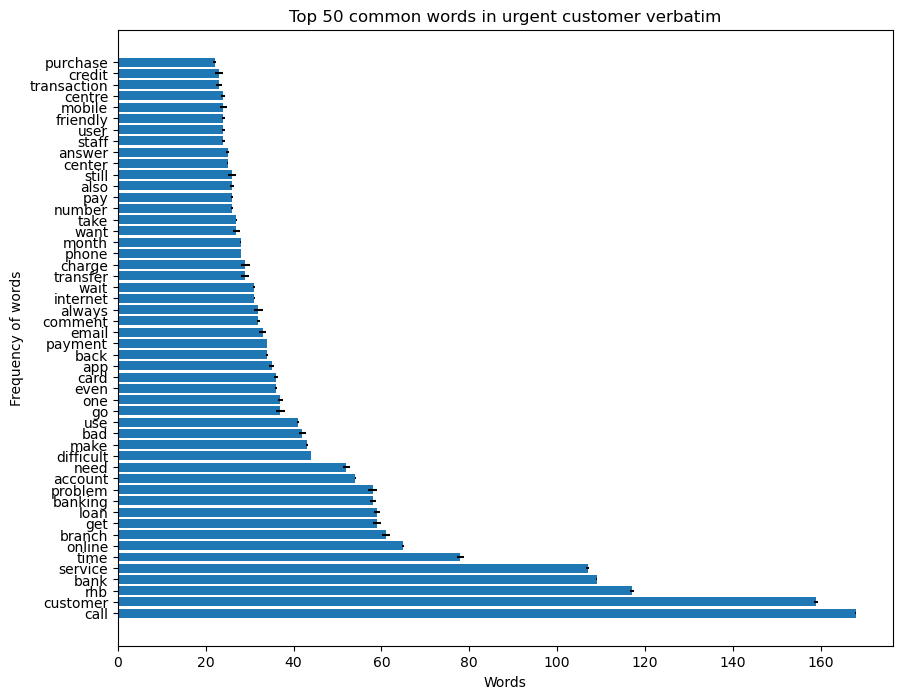

There were 436 feedbacks that were deemed to be negative, and the bar chart above represents the top 50 common topic of concern among those customers.


In [20]:
num_of_words = word_count(text)
sort_orders = sorted(num_of_words.items(), key=lambda x: x[1], reverse=True)
top_50_words_freq = 0
words, freq_of_words = [], []

for i in sort_orders:
    words += [i[0]]
    freq_of_words += [i[1]]
    if top_50_words_freq == 49:
        break
    
    top_50_words_freq += 1

    
# creating the bar plot
# fig = plot.figure(figsize = (20, 30))

plot.rcdefaults()
fig, ax = plot.subplots()

y_pos = np.arange(len(words))
performance = 3 + 10 * np.random.rand(len(words))
error = np.random.rand(len(words))

# plot.figure(figsize = (20, 30))
ax.barh(words, freq_of_words, xerr=error, align='center')
fig.set_figheight(8)
fig.set_figwidth(10)
 
# plot.bar(words, freq_of_words, color="#c69255",
#         width = 0.4)
 
plot.xlabel("Words")
plot.ylabel("Frequency of words")
plot.title("Top 50 common words in urgent customer verbatim")
plot.show()
print("There were " + str(len(test_data)) + " feedbacks that were deemed to be negative, and the bar chart above represents the top 50 common topic of concern among those customers.")